In [1]:
import tensorflow as tf

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
x = tf.Variable(tf.random_normal([1, 2], stddev=1, seed=1))
w = tf.Variable(tf.random_normal([2, 1], stddev=1, seed=1))
y_ = tf.Variable(tf.random_normal([1, 1], stddev=1, seed=1))
y = tf.matmul(x, w)

loss = tf.reduce_mean(tf.square(y_ - y)) + tf.contrib.layers.l2_regularizer(.5)(w)
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(loss))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
14.210822


In [5]:
# import tensorflow as tf

weight = tf.constant([[1.0, -2.0], [-3.0, 4.0]])
with tf.Session() as sess:
    # 输出为(|1| + |-2| + |-3| + |-4|) * 0.5 = 5 其中0.5 为正则化权重
    print(sess.run(tf.contrib.layers.l1_regularizer(.5)(weight)))
    # 输出为(|1|^2 + |-2|^2 + |-3|^2 + |-4|^2)/2 * 0.5 = 7.5 其中0.5 为正则化权重
    print(sess.run(tf.contrib.layers.l2_regularizer(.5)(weight)))

5.0
7.5


In [6]:
# Use random uniform values in [0, 1) as the initializer for a variable of shape
# [2, 3]. The default type is float32.
var = tf.Variable(tf.random_uniform([2, 3]), name="var")
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(var))

[[0.90811086 0.49931765 0.21857083]
 [0.63565886 0.37675166 0.8882961 ]]


In [7]:
# -0.5到0.5均匀分布的3*3数组
var = tf.Variable(tf.random_uniform([3, 3], minval=-0.5, maxval=0.5), name="var")
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(var))

[[ 0.41459298  0.17013311 -0.30135226]
 [-0.14424062 -0.49511337  0.26162457]
 [-0.15898156  0.2370615   0.15076554]]


In [12]:
bias = tf.Variable(tf.constant(0.1, shape=[5]))
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    print(sess.run(bias))

[0.1 0.1 0.1 0.1 0.1]


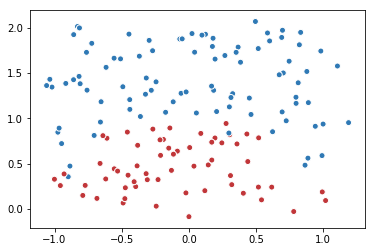

sample_size =  150


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,1]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_1', defined at:
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-b1e909e3465c>", line 38, in <module>
    y_ = tf.placeholder(tf.float32, shape=(None, 1))
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1680, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 4105, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,1]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

data = []
label = []
np.random.seed(0)

# 以原点为圆心，半径为1的圆把散点划分成红蓝两部分，并加入随机噪音。
for i in range(150):
    x1 = np.random.uniform(-1, 1)
    x2 = np.random.uniform(0, 2)
    if x1 ** 2 + x2 ** 2 <= 1:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(0)
    else:
        data.append([np.random.normal(x1, 0.1), np.random.normal(x2, 0.1)])
        label.append(1)
# reshape(-1,1) Numpy自动计算行数量
data = np.hstack(data).reshape(-1, 2)
label = np.hstack(label).reshape(-1, 1)
plt.scatter(data[:, 0], data[:, 1], c=label,
            cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.show()


# 获取一层神经网络边上的权重，并将这个权重的L2 正则化损失加入名称为'losses'的集合中
def get_weight(shape, lambda1):
    # 生成一个变量
    var = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # add_to_collection 函数将这个新生成的变量的L2正则化损失项加入集合
    # 这个函数的第一个参数'losses' 是集合的名字，第二个参数是要加入集合的内容
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(lambda1)(var))
    return var


x = tf.placeholder(tf.float32, shape=(None, 2))
y_ = tf.placeholder(tf.float32, shape=(None, 1))
sample_size = len(data)
print('sample_size = ', sample_size)
# 每层节点的个数
layer_dimension = [2, 10, 5, 3, 1]
# 神经网络的层数
n_layers = len(layer_dimension)

# 这个变量维护前向传播时最深沉的节点，开始的时候就是输入层
cur_layer = x
# 当前层节点的个数
in_dimension = layer_dimension[0]

# 循环生成网络结构
# 通过一个循环来生成5层全连接的神经网络
for i in range(1, n_layers):
    # layer_dimension[i] 为下一层节点的个数
    out_dimension = layer_dimension[i]
    # 生成当前权重的变量，并将这个变量的L2正则化损失加入计算图上的集合
    weight = get_weight([in_dimension, out_dimension], 0.003)
    # 生成shape(1,10)值为0.1的一维矩阵
    bias = tf.Variable(tf.constant(0.1, shape=[out_dimension]))
    # 使用ReLu激活函数
    # 书上为ReLU 源码为elu
    cur_layer = tf.nn.elu(tf.matmul(cur_layer, weight) + bias)
    in_dimension = layer_dimension[i]

y = cur_layer

# 损失函数的定义。# Loss = 平方差 + reg
mse_loss = tf.reduce_sum(tf.pow(y_ - y, 2)) / sample_size
tf.add_to_collection('losses', mse_loss)
# 列表中的元素相加
loss = tf.add_n(tf.get_collection('losses'))

train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
# 迭代次数
TRAINING_STEPS = 40000

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(TRAINING_STEPS):
        sess.run(train_op, feed_dict={x: data, y_: label})
        if i % 2000 == 0:
            print("After %d steps, loss: %f" % (i, sess.run(loss, feed_dict={x: data, y_: label})))

    # 画出训练后的分割曲线
    xx, yy = np.mgrid[-1:1:.01, 0:2:.01]
#     print('xx =', xx)
#     print('yy =', yy)
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = sess.run(y, feed_dict={x: grid})
    probs = probs.reshape(xx.shape)

plt.scatter(data[:, 0], data[:, 1], c=label,
            cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white")
plt.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.1)
plt.show()